In [1]:
import os
try:
    from google.colab import drive
    COLAB = True
    print("Estoy en Google CoLab")
    %tensorflow_version 2.x
    !pip install livelossplot
except:
    os.environ["CUDA_VISIBLE_DEVICES"]="0" 
    print("No estoy en Google CoLab")
    COLAB = False

No estoy en Google CoLab


In [2]:
# Cargamos las librerías necesarias para la práctica
import keras
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, LeakyReLU, Activation, Dropout
from tensorflow.keras.layers import Layer, Reshape, Conv2DTranspose, Lambda, ReLU, BatchNormalization, UpSampling2D
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.callbacks import ReduceLROnPlateau
try:
  from livelossplot import PlotLossesKeras
except:
  !pip install livelossplot
  from livelossplot import PlotLossesKeras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist, cifar10
from tqdm.notebook import tqdm
from io import BytesIO, StringIO
import inspect
import numpy as np
import cv2
import matplotlib
import os
import random
import pathlib
import re
from copy import copy
from livelossplot import PlotLosses
from utils import draw2compare

# %matplotlib inline
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (15,5) # Para el tamaño de la imagen
matplotlib.rcParams['figure.figsize'] = (15,5)

import seaborn as sns
import pandas as pd

Using TensorFlow backend.


In [ ]:
def draw2compare(*args, file_path=None):
    n = len(args[0])
    plt.figure(figsize=(20, 2*len(args)))
    for i in range(n):
        for j in range(len(args)):
            img = args[j][i]
            ax = plt.subplot(len(args), n, i + 1 + j*n)
            if len(img.shape) == 3 and img.shape[2] == 1:
                plt.imshow(img.reshape(img.shape[:2]))
            else:
                plt.imshow(img)

            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    
    if file_path:
        plt.savefig(file_path)
    else:
        plt.show()

In [3]:
import keras
keras.__version__

'2.3.0-tf'

# Redes generativas adversarias

## Introducción

Las Redes Generativas Adversarias (GNAs), fueron desarrolladas por Goodfellow y otros en 2014 como una alternativa a las VAEs para aprender espacios latentes de imágenes. Estas son capaces de generar imagenes sintéticas muy realistas forzando a que no se sea capaz de terminar si la imagen generada es real o no. 

Intuitivamente podemos pensar en un falsificador intentando crear un Picasso y enseñando su falsificación a un experto en arte. Este experto hará una valoración de cada falsificación que prepare. Con el tiempo el falsificador irá mejorando su falsificación, imitando mejor y mejor el estilo de Picasso hasta que el experto sea incapaz de determinar que se trata de una falsificación.

Esto es exactamente lo que hacen las GANs: la red falsifica y otra red hará de experta.
 - La red generadora (falsificador) toma como entrada un vector aleatorio (un punto aleatorio del espacio latente) y la decodifica a una imagen sintética.
 - La red adversaria (experta) tomará como entrada una imagen (que podrá ser real o sintética) y determinará si ésta es real o fue creada por la red generadora.
 
El hecho de entrenadar la red generadora para engañar a la red adversaria hará que la red generadora vaya generando imágenes cada vez más realistas. Mientras tanto, la red adversaria se va adaptando a las mejoras de la red generadora. Cuando el entrenamiento converge, el generador será capaz de decodificar cualquier vector en una imagen sintética y realista. Al menos suficiente realista como para engañar al experto. A diferencia de la VAEs, el espacio latente genenerado no tendrá ningun estructura útil ni será continuo.

<img src='https://hdvirtual.us.es/discovirt/index.php/s/Ba5PkLWbGeHAAs3/preview' width=70% />

Hay que destacar, que al entrenar una GAN el proceso de optimización no es fijo. En los ejemplos vistos hasta ahora,  siempre se tenía una superfice de error fija, pero con las GAN en cada iteración se modifica la superficie de error un poco. Es un sistema dinámico en el que el sistema de optimización no buscará un minímo sino un equilibrio entre dos fuerzas. Por esta razón, las GAN son especialmente dificiles de entrenar. Conseguir que una GAN funcione requiere de una cuidadosa optimización de los parámetros y de la arquitectura de las redes.


### Un boceto de la implementación

Vamos a ver como implementar una GAN en su forma más básica. Se han realizado avances significativos que requiren un estudio más profundo de detalles técnicos que quedan fuera de una introducción. Nuestra implementación será una GAN usando red convolucional conocida como DCGAN (el generador y el discriminador son redes convolucionales). Como en el ejemplo anterior usaremos la traspuesta de la convolución para pasar de un vector una imagen en el generador.

Entrenaremos nuestra GAN con imágenes de CELEBA. 

Esquematicamente, nuestra GAN hará lo siguiente:

* La red `generadora` mapeara vectores de tamaño  `(latent_dim,)` a imágenes de tamaño `(32, 32, 3)`.
* La red `discriminadora` mapeara images de tamaño (32, 32, 3) a una probabilidad entre 0 y 1.
* Uniremos las dos redes formando una cadena para formar la `gan`: `gan(x) = discriminador(generador(x))`. Esta composición nos dirá como de real es una imagen mapeada desde el espacio latente. 
* Entrenaremos el discriminador usando muestras reales y falsas generadas por el generador. Las muestras reales tendrán asociadas las etiqueta 1 y las generadas por el generador etiqueta 0. 
* Para entrenar el generador usaremos los gradientes resultado de usar como funcion de coste a la red `gan` anterior. Por tanto en cada iteración debemos actualizar los pesos del generador, de forma que hagamos que el discriminador vea las muestras generadas como más reales. 

### Un puñado de trucos

Como hemos mencionado, entrenar una GAN es complicado, por lo que hay una serie de trucos que hay que tener en mente. Como la mayoría de las cosas en Deep Learning, es más alquimia que ciencia. Estos trucos son heuristicos, no existe una teoría que los respalde. Si hay cierta idea intuitiva de porque funcionan y esta comprobado empíricamente, pero no necesariamente tiene que funcionar en todos los contextos.

Veamos algunos de los trucos que usaremos en nuestra implementación pero puedes encontrar más en la literatura:

* Usaremos la activación `tanh` como la última activación del generador envez de una `sigmoid` (como suele ser usada para modelos similares).
* Muestrearemos puntos del espacio latente usando una *distribución normal* envez de una distribución uniforme.
* La aleatoriedad nos ayuda a ganar robustez. Evitaremos que el entrenamiento se quede atascado. Introduciremos esta aletoriedad de dos formas:
  1. Podemos usar dropout en el discriminador.
  2. Añadiendo ruido a las etiquetas del discriminador.


* Los gradientes dispersos pueden dificultar el entrenamiento. En Deep Learning la dispersición es normalmente deseable, pero no con las GANs. Hay dos elementos que puede producir dispersión:
  1. Las operaciones Max Pooling. Usaremos convoluciones por un paso mayor a 1 para llevar a cabo la reducción de dimensionalidad.
  2. Podemos usar activaciones ReLU, pero las activaciones `LeakyReLU`, muy similar a la ReLU, reducen la dispersión permitiendo valores negativos de las activaciones.
    
* Las imágenes generadas puede presentar un efecto de cuadriculado. Para reducir este efecto podemos usar un tamaño de kernel divisible por el paso usado en la convolución y/o también establecer un paso de 1 en la última convolución. Otra opción es probar capas UpSampling2D.

<img src='https://hdvirtual.us.es/discovirt/index.php/s/ctodx2E5sLSRNdE/preview' width=60% />

### La implementación

Como con la pŕactica de los VAEs creamos nuestra clase DCGAN. Tendremos un método para crear el generador y otro para crear el discriminador.  Vamos ver el contenido del generador:

```
    def __create_generator(self):
        
        generator_input = Input(shape=(self.z_dim,), name='generator_input') #(1)
        x = generator_input

        x = Dense(np.prod(self.generator_initial_dense_layer_size))(x) #(2)
        
        x = Reshape(self.generator_initial_dense_layer_size)(x) #(3)
        
        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)
    
        if inspect.isclass(self.generator_activation) and Layer in self.generator_activation.__bases__:
            x = self.generator_activation()(x)
        elif isinstance(self.generator_activation, str):
            x = Activation(self.generator_activation)(x)
        
        if self.generator_dropout_rate:
            x = Dropout(rate = self.generator_dropout_rate)(x)
        
        n_layers_generator = len(self.generator_conv_filters)
        for i in range(n_layers_generator ):  #(4)
            if self.generator_use_transpose:
                x = Conv2DTranspose(
                        filters = self.generator_conv_filters[i]
                        , kernel_size = self.generator_conv_kernel_size[i]
                        , strides = self.generator_conv_strides[i]
                        , padding = 'same'
                        , name = 'generator_deconv_' + str(i)
                        )(x)

            else:
                x = UpSampling2D()(x)
                x = Conv2D(
                        filters = self.generator_conv_filters[i]
                        , kernel_size = self.generator_conv_kernel_size[i]
                        , padding = 'same'
                        , name = 'generator_conv_' + str(i)
                        )(x)
            
            if i < n_layers_generator - 1:
                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)
                    
                x = Activation('relu')(x)
                
            else:
                x = Activation('tanh')(x)   #(5)
        
        generator_output = x
        return Model(generator_input, generator_output)
```

  1. La entrada será un vector de tamaño `z_dim`.
  2. A la entrada le sigue un capa densa cuyo tamaño dependerá de las dimensiones definidas para la primera capa convolucional.
  3. Tras la capa convolucional podemos aplicar normalización en batch y la correspondiente activación.
  4. Seguimos estacando capas transpuestas o de UpSampling2D, según hayamos definido en el contrustructor mediante el atributo `generator_use_transpose`.
  5. La última capa tendrá una activación `tanh`
  
En el discriminador tenemos el siguiente código:

```
def __create_discriminator(self):
        discriminator_input = Input(shape=self.input_dim, name='discriminator_input')  #(1)
        x = discriminator_input
        for i in range(len(self.discriminator_conv_filters)):                          #(2)
            conv_layer = Conv2D(
                filters = self.discriminator_conv_filters[i],
                kernel_size = self.discriminator_conv_kernel_size[i],
                strides = self.discriminator_conv_strides[i],
                padding = 'same',
                name = 'discriminator_conv_' + str(i)
            )
 
            x = conv_layer(x) 
    
            if self.discriminator_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum = self.discriminator_batch_norm_momentum)(x)

            if inspect.isclass(self.discriminator_activation) and 
               Layer in self.discriminator_activation.__bases__:
                x = self.discriminator_activation()(x)
            elif isinstance(self.generator_activation, str):
                x = Activation(self.discriminator_activation)(x)
            
            if self.discriminator_dropout_rate:
                x = Dropout(rate = self.discriminator_dropout_rate)(x)            

        x = Flatten()(x) #(3)
              
        discriminator_output= Dense(1, activation='sigmoid', 
                                    kernel_initializer = self.weight_init)(x)   #(4)
        
       
        return Model(discriminator_input, discriminator_output)   #(5)
```

  1. Definimos la entrada del discirminador (una imagen)
  2. Estacamos la capas convolucionales.
  3. Aplanamos la salida de la última capa para crear un vector.
  4. Añadimos una capa densa de tamaño 1 con una sigmoide como capa de activación para transformar la salida de la capa densa en valores entre 0 y 1.
  5. Creamos el modelo indicando la entrada y la salida de éste.
  
Además vamos a añadirle a nuestra clase un método de entrenamiento. Este método va a recibir un generador como parámetro y los optimizadores a usar en el generador y en el discriminador. 

Recordemos el proceso de entrenamiento. Por cada iteración (o época):
   * Muestrear vectores aleatorios del espacios latente (agregando un ruido aleatorio).
   * Generar imagánes con el generador usando estos vectores.
   * Mezclar la imagenes generadas con imágenes reales.
   * Entrenar el `discriminador` usando la mezcla anterior de imágenes con su correspondiente etiqueta (podemos añadir ruido a las etiquetas).
   * Muestrear nuevos vectores aleatorios del espacio latente.
   * Entrenar la *gan* usando esos vectores aleatorios pero con etiquetas diciendo que son reales. Esto hará que se actualicen los pesos del generador, pero haciendo que las imagenes generadas parezcan más reales al discriminador.


El código completo de la clase quedaría:

In [4]:
from keras.layers import LeakyReLU
import inspect

class DCGAN:
    
    def __init__(self, 
                 input_dim, 
                 discriminator_conv_filters, 
                 discriminator_conv_kernel_size, 
                 discriminator_conv_strides,
                 discriminator_normalization,
                 discriminator_dropout_rate,
                 discriminator_activation,
                 generator_initial_dense_layer_size,
                 generator_conv_filters, 
                 generator_conv_kernel_size, 
                 generator_conv_strides, 
                 generator_normalization,
                 generator_dropout_rate,
                 generator_activation,
                 generator_use_transpose,
                 z_dim,
                 weight_init="glorot_uniform",
                 generator_upsampling_size=None,
                 add_label_noise=True,
                 verbose=100):
    
        self.input_dim = input_dim
        self.discriminator_conv_filters = discriminator_conv_filters
        self.discriminator_conv_kernel_size = discriminator_conv_kernel_size
        self.discriminator_conv_strides = discriminator_conv_strides
        self.discriminator_normalization = discriminator_normalization
        self.discriminator_dropout_rate = discriminator_dropout_rate
        self.discriminator_activation = discriminator_activation
        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_normalization = generator_normalization
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_activation = generator_activation
        self.generator_upsampling_size = generator_upsampling_size,
        self.generator_use_transpose = generator_use_transpose
        self.weight_init = weight_init
        self.z_dim = z_dim
        self.add_label_noise = add_label_noise
        self.verbose = verbose
        
        self.discriminator = self._create_discriminator()
        self.generator = self._create_generator()
        
        self.image_history = []
    
            
    def _create_discriminator(self):

        discriminator_input = Input(shape=self.input_dim, name='discriminator_input') 
        x = discriminator_input
        for i in range(len(self.discriminator_conv_filters)):
            conv_layer = Conv2D(
                filters = self.discriminator_conv_filters[i],
                kernel_size = self.discriminator_conv_kernel_size[i],
                strides = self.discriminator_conv_strides[i],
                padding = 'same',
                name = 'discriminator_conv_' + str(i),
                kernel_initializer = self.weight_init
            )
 
            x = conv_layer(x) #(2)
    
            if self.discriminator_normalization and i > 0:
                x = BatchNormalization(**self.discriminator_normalization)(x)

            x = self._add_activation(x)


            if self.discriminator_dropout_rate:
                x = Dropout(rate = self.discriminator_dropout_rate)(x)            

        x = Flatten()(x) #(3)
              
        discriminator_output= Dense(1, activation='sigmoid', 
                                    kernel_initializer = self.weight_init)(x)
        
       
        return Model(discriminator_input, discriminator_output)
    
    
    def _create_generator(self):

        generator_input = Input(shape=(self.z_dim,), name='generator_input')
        x = generator_input

        x = Dense(np.prod(self.generator_initial_dense_layer_size))(x)

        if self.generator_normalization is not None:
            x = BatchNormalization(**self.generator_normalization)(x)

        x = Reshape(self.generator_initial_dense_layer_size)(x)
        
    
        x = self._add_activation(x)

        
        if self.generator_dropout_rate:
            x = Dropout(rate = self.generator_dropout_rate)(x)
        
        n_layers_generator = len(self.generator_conv_filters)
        for i in range(n_layers_generator ):
            if self.generator_use_transpose:
                x = Conv2DTranspose(
                        filters = self.generator_conv_filters[i]
                        , kernel_size = self.generator_conv_kernel_size[i]
                        , strides = self.generator_conv_strides[i]
                        , padding = 'same'
                        , name = 'generator_deconv_' + str(i)
                        , kernel_initializer = self.weight_init 
                        )(x)

            else:
                x = UpSampling2D()(x)
                x = Conv2D(
                        filters = self.generator_conv_filters[i]
                        , kernel_size = self.generator_conv_kernel_size[i]
                        , padding = 'same'
                        , name = 'generator_conv_' + str(i)
                        , kernel_initializer = self.weight_init
                        )(x)
            
            if i < n_layers_generator - 1:
                if self.generator_normalization is not None:
                    x = BatchNormalization(**self.generator_normalization)(x)
                    
                x = Activation(self.generator_activation)(x)
                
            else:
                x = Activation('tanh')(x)
        
        generator_output = x
        return Model(generator_input, generator_output)
        
        
    def train(self, epochs, generator, dis_optimizer, gen_optimizer, *args, **kwargs):
        # obtenemos el tamaño del batch del generador de datos
        self.batch_size = generator.batch_size
        
        # compilamos los modelos
        self._compile_models(dis_optimizer, gen_optimizer)
        
        # muestremos los vectores de entrada para ir
        # mostrando 10 muestras generadas durante el entrenamiento
        fixed_noise = np.random.normal(0, 1, (10, self.z_dim))
        
        plot_initialized = False
        finish = False
        epoch_counter = 0
        while epoch_counter <= epochs:
            print("Epoch %d" % epoch_counter)
            for b in tqdm(range(len(generator))):
                # entrenamos el generador y el discriminador
                losses = self._train_on_batch(generator, dis_optimizer, gen_optimizer, *args, **kwargs)
                
                # mostramos gráficos y muestras generadas
                if b % self.verbose == 0:
                    graph_data = {'%s_%s' % (kk, k): losses[k][kk] for k in losses.keys()
                                  for kk in losses[k].keys()}
                   
                        
                    if not plot_initialized:
                        groups = {k: ['%s_%s' % (kk, k) for kk in losses[k].keys()] for k in losses.keys()}
                        plotlosses = PlotLosses(groups=groups)
                        plot_initialized = True
                        
                    plotlosses.update(graph_data)
                    plotlosses.send()
                    
                    self.image_history.append((
                        np.clip(self.generator.predict(fixed_noise), 0, 1), 
                        np.clip(self.generate(10), 0, 1)))
                    draw2compare(*self.image_history[-1])
                    
                epoch_counter += 1
                
                if epoch_counter >= epochs:
                    break
            
    def _train_on_batch(self, *args, **kwargs):
        # obtenemos el batch
        x_train = generator.__next__()
        batch_size = x_train.shape[0]
        
        # entrenamos el generador
        dis_real_loss, dis_fake_loss = self._train_discriminator(x_train, batch_size)
        
        # entrenamos el discriminador con el doble de muestras
        gen_loss = self._train_generator(2*batch_size)
        
        # devolvemos los errores
        return {
            'loss': {
                'dis_real': dis_real_loss[0],
                'dis_fake': dis_fake_loss[0],
                'gen': gen_loss[0],
            },
            
            'acc': {
                'dis_real': dis_real_loss[1],
                'dis_fake': dis_fake_loss[1],
                'gen': gen_loss[1],              
            }
        }
    
    def _train_generator(self, batch_size):
        # el generador espera que el discriminador considere sus
        # muestras generadas reales -> 1
        valid = np.ones((batch_size,1))
        
        # vectores de entrada muestreados desde una 
        # distribución normal
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        
        return self.model.train_on_batch(noise, valid)
          
    def _train_discriminator(self, x_train, batch_size):
        # creamos las respuestas esperadas:
        #    1 para las muestras reales
        #    0 para las muestras falsas (generadas)
        valid, fake  = np.ones((batch_size, 1)), np.zeros((batch_size, 1))
        
        
        # se ha activado la generación de ruido en las etiquetas...
        if self.add_label_noise:
            valid = valid - 0.05 * np.random.uniform(0, 1, valid.shape)
            fake = fake  + 0.05 * np.random.uniform(0, 1, fake.shape)
        
        labels = np.concatenate([valid, fake])
        
        # creamos los vectores de entreada del generador y
        # generamos las muestras falsas
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        # combinamos las muestras reales y las falsas
        combined_images = np.concatenate([x_train, gen_imgs])
        
        
        # entrenamos
        self.discriminator.train_on_batch(x_train, valid)
        
        # obtenemos los errores
        real_loss = self.discriminator.train_on_batch(x_train, valid)
        fake_loss = self.discriminator.train_on_batch(gen_imgs, fake)
        
        return real_loss, fake_loss

    def set_trainable(self, model, is_trainable):
        """
        Acitva o desactiva el entrenamiento en las 
        capas de un modelo
        """
        model.trainable = is_trainable
        for l in model.layers:
            l.trainable = is_trainable

    def _compile_models(self, dis_optimizer, gen_optimizer):
        """
        Compila el generador y el discriminador
        """
        self.set_trainable(self.discriminator, True)
        self.discriminator.compile(
            optimizer=dis_optimizer, 
            loss = 'binary_crossentropy', 
            metrics = ['accuracy']
        )
        
        # Compilamos el modelo que entrenará al generador
        # como la unión del generador y el discriminador
        self.set_trainable(self.discriminator, False)
        model_input = Input(shape=(self.z_dim,), name='model_input')
        model_output = self.discriminator(self.generator(model_input))
        
        self.model = Model(model_input, model_output)
        self.model.compile(
            optimizer=gen_optimizer, 
            loss='binary_crossentropy', 
            metrics=['accuracy']
        )
            
    def _add_activation(self, x):
        if inspect.isclass(self.discriminator_activation) and Layer in self.discriminator_activation.__bases__:
            x = self.discriminator_activation()(x)
        elif isinstance(self.discriminator_activation, str):
            x = Activation(self.discriminator_activation)(x)
        elif self.discriminator_activation is not None:
            a = self.discriminator_activation
            activation = a.__class__(**{p: getattr(a, p) for p 
                                        in inspect.getfullargspec(a.__class__.__init__).args[1:]})
            x = activation(x)
        
        return x
    

    def generate(self, batch_size):
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.generator.predict(noise)

Vamos a a entrenar nuestro DCGAN para genear caras usando el dataset CelebA, ya usado en la práctica anterior:

In [5]:
data_path = keras.utils.get_file(
    "celeba.tar.gz",
    "https://hdvirtual.us.es/discovirt/index.php/s/9KMEFpajdzgDAC9/download",
    extract=True,
    archive_format='tar'
)

DATA_FOLDER = pathlib.Path(data_path).parent / 'celeba' 
IMG_FOLDER = os.path.join(DATA_FOLDER, 'images')
# csv con los atributos de cada imágen (gafas, rubio, gorra, ...)
att_file = os.path.join(DATA_FOLDER, 'att.csv')

# obtenemos los nombres de los archivos de imágenes
file_names = os.listdir(IMG_FOLDER)
print('Total de imagenes: %d' % len(file_names))

# cargamos en memoria todo el conjunto de datos
im_bytes = [open(os.path.join(DATA_FOLDER, 'images', f), 'rb').read() for f in tqdm(file_names)]

Total de imagenes: 202599


Nos creamos el generador indicando que vamos a recorgar el 20% de los bordes para quedarmos en su mayor con las caras con un tamaño de 64x64 pixeles:

In [5]:
class CelebaInMemoryIterator(keras.utils.Sequence):
       
    def __init__(self, im_bytes, batch_size, shuffle=True, output_type=None, 
                 input_shape=(128, 128), crop=False, crop_pct=0.1, scaling_range=(0,1)):
        self.im_bytes = im_bytes
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.output_type = output_type
        self.input_shape = input_shape
        self.crop=crop
        self.crop_pct = crop_pct
        self.scaling_range = scaling_range

        self.__len = int(len(self.im_bytes) / self.batch_size)
        
        self.reset()

    def __len__(self):
        return self.__len

    def __getitem__(self, index):
        # comienzo y final del batch
        i = index * self.batch_size
        j = i + self.batch_size
        
        # indixes del batch
        indexes = self.__indexes[i:j]
        
        # imagenes binarias del batch
        batch = [self.im_bytes[k] for k in indexes]

        # lista final de arrays
        ims = []
   
        # convertimos a numpy arrays
        for im in batch:
            b = BytesIO(im)
            file_bytes = np.asarray(bytearray(BytesIO(im).read()), dtype=np.uint8)
            im = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
            if self.crop:
                w, h = im.shape[:2]
                l,r = int(w*self.crop_pct), w - int(w*self.crop_pct)
                u, b = int(h*self.crop_pct), h - int(h*self.crop_pct)
                im = im[l:r, u:b, :]
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            im = cv2.resize(im, self.input_shape) 
            ims.append(im)

        # escalamo
        ims = ((np.array(ims).astype('float') / 255) * (self.scaling_range[1] - self.scaling_range[0])) + self.scaling_range[0] 
        
        if self.output_type == 'same':
            return ims, ims
        elif self.output_type is None:
            return ims
        
    def on_eponch_end(self):
        self.reset()
        
    def reset(self):
        self.__indexes = list(range(len(self.im_bytes)))           
        if self.shuffle:
            self.__indexes = random.sample(self.__indexes, len(self.__indexes))
        self.__current_index = 0

    def __iter__(self):
        return self

    def __next__(self, *args, **kwargs):
        # si hemos llegado al final reiniciamos
        if self.__current_index >= self.__len:
            self.reset()
            
        # cogemos el siguiente batch
        r =  self.__getitem__(self.__current_index)
        
        # incrementamos el indice
        self.__current_index += 1
        
        return r
    
generator = CelebaInMemoryIterator(im_bytes, 16, input_shape=(64,64), crop=True, crop_pct=0.2)
generator.__next__().shape

(16, 64, 64, 3)

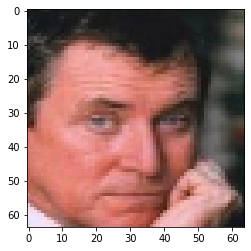

In [6]:
plt.imshow(generator.__next__()[0])

Nos creamos nuestra DCGAN con los siguiente parámetros:

In [7]:
gan = DCGAN(input_dim = (64, 64, 3)
        , discriminator_conv_filters = [64,128,128]
        , discriminator_conv_kernel_size = [4,4,4]
        , discriminator_conv_strides = [2,2,2]
        , discriminator_normalization = None 
        , discriminator_activation = LeakyReLU(0.2)
        , discriminator_dropout_rate = None
        , generator_initial_dense_layer_size = (8, 8, 128)
        , generator_conv_filters = [128, 256, 512, 3]
        , generator_conv_kernel_size = [4,4,4, 5]
        , generator_conv_strides = [2,2, 2, 1]
        , generator_normalization = None 
        , generator_activation = LeakyReLU(0.2)
        , generator_dropout_rate = None
        , z_dim = 128,
          generator_use_transpose = True
)


Podemos ver la estructura del discriminador y el generador:

In [8]:
gan.generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
generator_deconv_0 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
activation (Activation)      (None, 16, 16, 128)       0         
_________________________________________________________________
generator_deconv_1 (Conv2DTr (None, 32, 32, 256)       5245

In [9]:
gan.discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 64, 64, 3)]       0         
_________________________________________________________________
discriminator_conv_0 (Conv2D (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
discriminator_conv_1 (Conv2D (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
discriminator_conv_2 (Conv2D (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0     

Entrenamos:

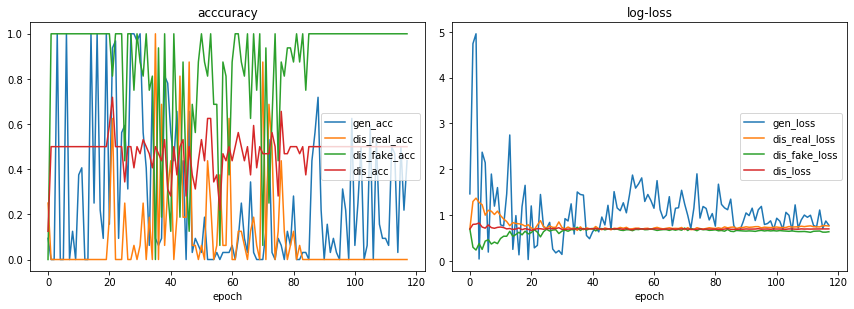

acccuracy
	gen_acc          	 (min:    0.000, max:    1.000, cur:    0.438)
	dis_real_acc     	 (min:    0.000, max:    1.000, cur:    0.000)
	dis_fake_acc     	 (min:    0.000, max:    1.000, cur:    1.000)
	dis_acc          	 (min:    0.000, max:    1.000, cur:    0.500)
log-loss
	gen_loss         	 (min:    0.000, max:   16.118, cur:    0.778)
	dis_real_loss    	 (min:    0.000, max:   16.118, cur:    0.761)
	dis_fake_loss    	 (min:    0.000, max:   15.942, cur:    0.637)
	dis_loss         	 (min:    0.009, max:    7.971, cur:    0.699)


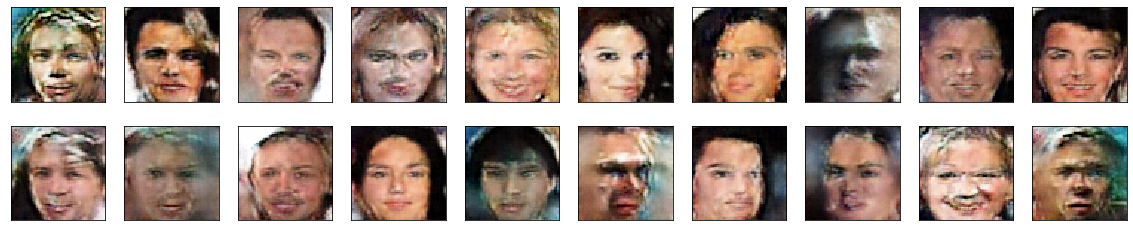

In [ ]:
gan.train(2000, 
          generator, 
          dis_optimizer=Adam(0.0001, 0.5, decay=0.00005),
          gen_optimizer=Adam(0.0001, 0.5, decay=0.00005))

Tras finalizar el entrenamiento vemos que le generador es capaz de crear nuevas caras, aunque la calidad deja algo que desear en la mayoría de los casos. En otros casos se han generado caras con bastante calidad. 

Respecto al entrenamiento, vemos que es complicado ver una progresió en las gráficas. Como ya se comentó en las clases de teoría, este es uno de grandes problemas de las primeras GANS, la difícil interpretación de la loss.

Vamos a ver las WGAN que intentan solucionar alguno de dos estos problemas:

## Wasserstein GAN

Para implementa la WGAN vamos a extender la clase anterior. Recordamos que en las WGAN llevan a cabo varias modificaciones:

  1. se cambia la función de loss pasando a usar la distancia de wasserstein (definida el método `_wasserstein`).
  2. Se hace un truncado de los pesos del discriminador. Este truncado se configura en el parámetro `clip_threshold` y se lleva a cabo tras el entrenamiento. Para ello se ha sobreescrito el método `_train_discriminator`.
  3. La activación de salida del discriminador se cambia de sigmoide a lineal. Esta modificación se hace sobreescribiendo el método `_create_discriminator`.
  4. Las etiquetas del discriminador pasan de ser 0,1 a ser -1,1. Este cambio se puede ver en la primera línea del método `_train_discriminator`.

In [15]:
from keras import backend as k
class WGAN(DCGAN):
    
    def __init__(self, clip_threshold=0.01, critic_iterations=5, *args, **kwargs):
        super(WGAN, self).__init__(*args, **kwargs)
        
        self.clip_threshold = clip_threshold
        self.critic_iterations = critic_iterations
        
    def _accurracy(self, y_true, y_pred):
        y_pred = (y_pred >= 0)
        y_true = (y_true >= 0)
        
        return keras.backend.mean(keras.backend.equal(y_true, y_pred)) 
        
    def _wasserstein(self, y_true, y_pred):
        return -K.mean(y_true * y_pred) 
    
    def _compile_models(self, dis_optimizer, gen_optimizer):

        # Bloqueamos el entrenamiento el generador
        self.set_trainable(self.discriminator, True)
        self.set_trainable(self.generator, False)

        self.discriminator.compile(
            optimizer=dis_optimizer, 
            loss =self._wasserstein, 
            metrics = [self._accurracy]
        )
        
        # Compilamos el modelo que entrenará al generador
        self.set_trainable(self.generator, True)
        self.set_trainable(self.discriminator, False)
        
        
        model_input = Input(shape=(self.z_dim,), name='model_input')
        model_output = self.discriminator(self.generator(model_input))
        
        self.model = Model(model_input, model_output)
        self.model.compile(
            optimizer=gen_optimizer, 
            loss=self._wasserstein, 
            metrics=[self._accurracy]
        )
        self.set_trainable(self.discriminator, True)

    def _train_on_batch(self, generator, dis_optimizer, gen_optimizer, *args, **kwargs):
        
        x_train = generator.__next__() 
        batch_size = x_train.shape[0]
        for _ in range(self.critic_iterations):
            dis_real_loss, dis_fake_loss = self._train_discriminator(x_train, batch_size)
        
        batch_size = generator.batch_size
        gen_loss = self._train_generator(batch_size)
        
        return {
            'loss': {
                'dis_real': dis_real_loss[0],
                'dis_fake': dis_fake_loss[0],
                'gen': gen_loss[0],
            },
            
            'acc': {
                'dis_real': dis_real_loss[1],
                'dis_fake': dis_fake_loss[1],
                'gen': gen_loss[1],              
            }
        }
        

    def _train_discriminator(self, x_train, batch_size, labels=(1, 0)):
        # emtremamos llamando a la clase DCGAN
        real_loss, fake_loss = super(WGAN, self)._train_discriminator(x_train, batch_size, labels=(1., -1.))

        # truncado de los pesos
        for l in self.discriminator.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -self.clip_threshold, self.clip_threshold) for w in weights]
            l.set_weights(weights)
            
        return real_loss, fake_loss
    
    def _create_discriminator(self):
        # creamos el descriminador
        discriminator = super(WGAN, self)._create_discriminator()
        
        # cambiamos la activación de la salida
        discriminator.layers[-1].activation = keras.activations.linear
        
        return discriminator
        
        

Una vez creada la clase nos creamos nuestro WGAN:

In [432]:
gan = WGAN(input_dim = (64, 64, 3)
        , discriminator_conv_filters = [64,128,256,512]
        , discriminator_conv_kernel_size = [5,5,5,5]
        , discriminator_conv_strides = [2,2,2,2]
        , discriminator_normalization = BatchNormalization(momentum=0.8)
        , discriminator_activation = 'relu' 
        , discriminator_dropout_rate = None
        , generator_initial_dense_layer_size = (4, 4, 512)
        , generator_conv_filters = [256, 128, 64, 3]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [2, 2, 2, 2]
        , generator_normalization = None 
        , generator_activation = 'relu' 
        , generator_dropout_rate = None
        , z_dim = 100,
          generator_use_transpose = True,
          add_label_noise = False,
          verbose=5,
          clip_threshold=0.01,
          weight_init= RandomNormal(mean=0., stddev=0.02),
          critic_iterations = 5
)


y entrenamos:

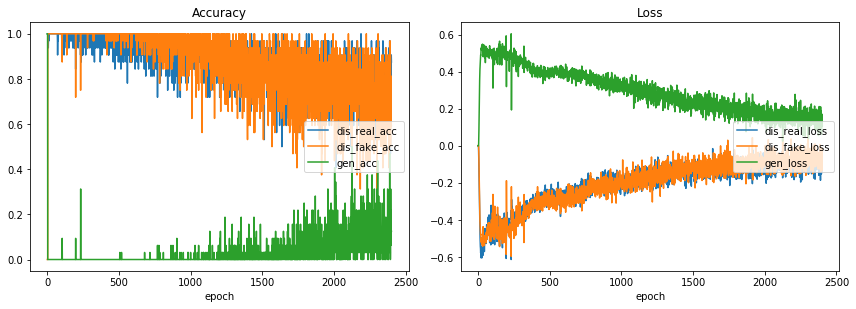

Accuracy
	dis_real_acc     	 (min:    0.125, max:    1.000, cur:    0.875)
	dis_fake_acc     	 (min:    0.000, max:    1.000, cur:    0.594)
	gen_acc          	 (min:    0.000, max:    1.000, cur:    0.125)
Loss
	dis_real_loss    	 (min:   -0.708, max:    0.272, cur:   -0.091)
	dis_fake_loss    	 (min:   -0.678, max:    0.407, cur:   -0.022)
	gen_loss         	 (min:   -0.562, max:    0.662, cur:    0.108)


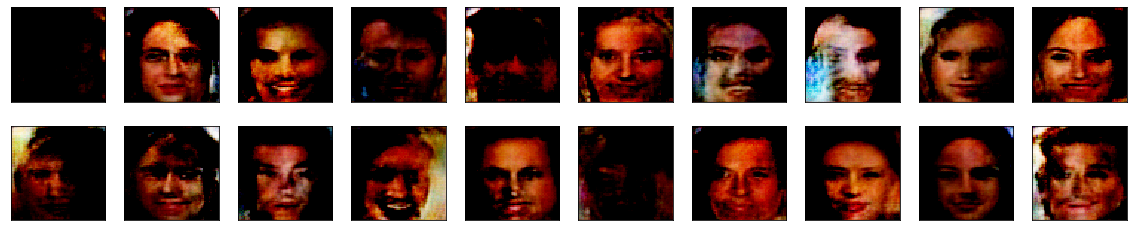

In [215]:
generator = celeba.CelebaInMemoryIterator(im_bytes, 32, input_shape=(64,64), crop=True, crop_pct=0.2,
                                         scaling_range=(-1, 1))

gan.train(12000, 
          generator, 
          dis_optimizer=RMSprop(lr=5e-5),
          gen_optimizer=RMSprop(lr=5e-5))

En primer lugar comentar que en el artículo no se usa este dataset y se conoce que este tipo de GAN no suele dar buenos resultados con este conjunto de datos. 

Lo que si este interesante es la evolución del entrenamiento. Vemos en la gráfica que ahora si vemos una clara interpretación. A medida que se avanza en el entremiento vemos la convergencia en la función de coste.

Las WGAN eras críticadas sobre todo por el truncado de los pesos. Vamos a ver las WGANGP que solucionan este inconviente:

### WGAN-GP

En primer lugar vamos a necesitar una nueva capa para llevar a cabo la *interpolación* entre las muestras generadas y las reales:

In [18]:
class RandomWeightedAverage(tf.keras.layers.Layer):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size

    def call(self, inputs, **kwargs):
        alpha = tf.random_uniform((self.batch_size, 1, 1, 1)) # (1)
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1]) #  (2)

    def compute_output_shape(self, input_shape):
        return input_shape[0]
    

  1. Por cada imagen en el batch generamos un vector uniforme de floats entre 0 y 1. Este será la aportación de la imagen real y la generada a lo largo de esa *linea recta*.
  2. La capa devolverá la interpolación a lo largo de dicha línea que conecta la imagen real y la generada.
  
También vamos a necesitar una nueva función para calcular la penalización sobre la función de coste en base a las imágenes interpoladas:

In [19]:
def gradient_penalty_loss(y_true, y_pred, interpolated_samples):
    gradients = K.gradients(y_pred, interpolated_samples)[0] # (1)
    gradient_l2_norm = K.sqrt(
        K.sum(
            K.square(gradients), axis=np.arange(1, len(gradients_sqr.shape))
        )
    ) # (2)
    gradient_penalty = K.square(1 - gradient_l2_norm)
    return K.mean(gradient_penalty) # (3)

  1. Obtenemos los gradientes de las predicciones respecto a las interpolaciones.
  2. Calculamos la norma L2.
  3. Devolvemos la distancia al cuadrado entre la norma L2 y 1.
  
Para introducir este penalty usamos la función `partial` de `functools` que nos permite **pre-asignar** parámetros de una función. En nuestro caso vamos a pre-asignar el parámetro `interpolated_samples`

```
        validity_interpolated = self.discriminator(interpolated_img)

        partial_gp_loss = partial(self.gradient_penalty_loss,
                          interpolated_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty'
        
```        

Al compilar el modelo podemos establer la función de coste como una suma ponderada de varias funciones de coste. Para ello nuestro modelo dará 3 salidas: la predicción sobre las muestras reales, la predicción sobre las muestras falsas y la predicción de las interpolaciones. Con el parámetro `loss_weights` indicamos el peso de cada loss establecida en el parámetro `loss`. Una por cada salida:

```
    self.critic_model = Model(inputs=[real_img, z_disc],
                outputs=[valid, fake, validity_interpolated])

    self.critic_model.compile(
            loss=[self._wasserstein, self._wasserstein, partial_gp_loss], 
            loss_weights=[1, 1, self.grad_weight], optimizer=dis_optimizer
        )
```      

Sobre el resto de la implementación, debemos sobreescribir `_train_on_batch` para quitar el truncado y `_train_discriminator` para dar las salidas dummy correspondientes a las muestras de la interporlación.

In [20]:
from functools import partial
class WGANGP(WGAN):
    
    def __init__(self, clip_threshold=0.01, grad_weight=10, *args, **kwargs):
        super(WGANGP, self).__init__(*args, **kwargs)
        
        self.clip_threshold = clip_threshold
        self.grad_weight = grad_weight

    def gradient_penalty_loss(self, y_true, y_pred, interpolated_samples):
        """
        Calculamos la penalización usando las interpolaciones
        """
        gradients = K.gradients(y_pred, interpolated_samples)[0]

        # cuadrado de los gradientes
        gradients_sqr = K.square(gradients)
        # sumamos por filas
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        # y le hacemos la raiz cuadrada, lo que nos da la norma l2
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        
        # el cuadrado de (1 - la norma l2)
        gradient_penalty = K.square(1 - gradient_l2_norm)
        
        # y devolvemos la media por muestra
        return K.mean(gradient_penalty)
    
    def _compile_models(self, dis_optimizer, gen_optimizer):
        
        #------------------------------------------
        # Construcción del crítico (discriminador)
        #--------------------------------------------
        
        # Bloqueamos el entrenamiento del generador
        self.set_trainable(self.generator, False)

        # imagen real
        real_img = Input(shape=self.discriminator.layers[0].input_shape[1:])

        # imagen falsa
        z_disc = Input(shape=(self.z_dim,))
        fake_img = self.generator(z_disc)

        # obtenemos los tensores del discriminador
        # para imágnes reales e imágenes falsas
        fake = self.discriminator(fake_img)
        valid = self.discriminator(real_img)

        # Creamos la media ponderada entre la imagen real y la falsa
        interpolated_img = RandomWeightedAverage(self.batch_size)([real_img, fake_img])
        
        # Obtenemos la respuesta del discriminado sobre esa interpolación
        validity_interpolated = self.discriminator(interpolated_img)

        # Usamos partial para crear la loss
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          interpolated_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requiere un nombre

        self.critic_model = Model(inputs=[real_img, z_disc],
                            outputs=[valid, fake, validity_interpolated])

        self.critic_model.compile(
            loss=[self._wasserstein, self._wasserstein, partial_gp_loss], 
            loss_weights=[1, 1, self.grad_weight], optimizer=dis_optimizer,
            metrics=[self._accurracy]
        )
        
        #===============================
        # Creación del generador
        #===============================

        # Bloqueamos al discriminador
        self.set_trainable(self.discriminator, False)
        self.set_trainable(self.generator, True)

        # Entrada
        model_input = Input(shape=(self.z_dim,))
        
        # Generamos la imagen a partir del vector ruidoso
        img = self.generator(model_input)
        
        # Obtenemos la respuesta del discriminador
        model_output = self.discriminator(img)
        
        # Creamos el modelo
        self.model = Model(model_input, model_output)
        
        self.model.compile(optimizer=gen_optimizer, 
                           loss=self._wasserstein, 
                          metrics=[self._accurracy])

       

    def _train_on_batch(self, generator, dis_optimizer, gen_optimizer, num_steps, *args, **kwargs):
        x_train = generator.__next__()
        batch_size = x_train.shape[0]

        for _ in range(5):
            dis_real_loss, dis_fake_loss, _, _ = self._train_discriminator(x_train, batch_size)
            
        
        batch_size = generator.batch_size
        gen_loss = self._train_generator(batch_size)
        
        return {
            'loss': {
                'dis_real': dis_real_loss[0],
                'dis_fake': dis_fake_loss[0],
                'gen': gen_loss[0],
            },
            
            'acc': {
                'dis_real': dis_real_loss[1],
                'dis_fake': dis_fake_loss[1],
                'gen': gen_loss[1],              
            }
        }
        

    def _train_discriminator(self, x_train, batch_size, labels=(1, -1)):
        batch_size = x_train.shape[0]
        valid = np.ones((batch_size,1), dtype=np.float32) * labels[0]
        fake = np.ones((batch_size,1), dtype=np.float32) * labels[1]
        dummy = np.zeros((batch_size, 1), dtype=np.float32) # Dummy gt for gradient penalty

        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        
        d_loss = self.critic_model.train_on_batch([x_train, noise], [valid, fake, dummy])
        return d_loss

Entremos como en los casos anteriores. En este caso no usamos normalización en el discriminador:

In [467]:
generator = celeba.CelebaInMemoryIterator(im_bytes, 64, input_shape=(64,64), crop=True, crop_pct=0.2,
                                         scaling_range=(0, 1))

wgan_gp = WGANGP(input_dim = (64, 64, 3)
        , discriminator_conv_filters = [64,128,256,512]
        , discriminator_conv_kernel_size = [5,5,5,5]
        , discriminator_conv_strides = [2,2,2,2]
        , discriminator_normalization = None
        , discriminator_activation = LeakyReLU(alpha = 0.2)
        , discriminator_dropout_rate = None
        , generator_initial_dense_layer_size = (4, 4, 512)
        , generator_conv_filters = [256, 128, 64, 3]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [2, 2, 2, 2]
        , generator_normalization = BatchNormalization(momentum=0.9)
        , generator_activation = LeakyReLU(alpha = 0.2)
        , generator_dropout_rate = None
        , z_dim = 100,
          generator_use_transpose = True,
          add_label_noise = False,
          verbose=5,
          weight_init= RandomNormal(mean=0., stddev=0.02)
)

/opt/anaconda/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


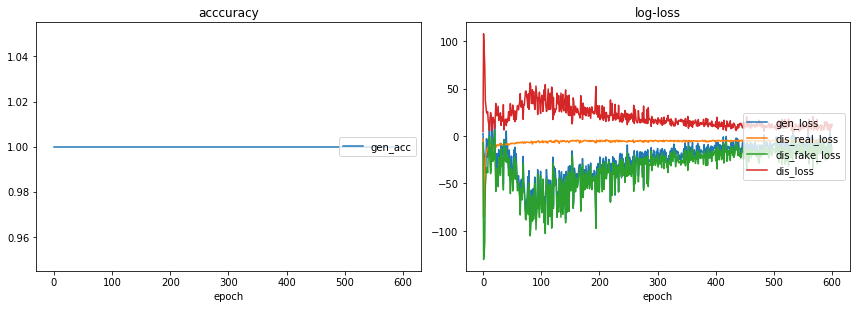

acccuracy
	gen_acc          	 (min:    1.000, max:    1.000, cur:    1.000)
log-loss
	gen_loss         	 (min:  -95.734, max:   16.692, cur:  -13.543)
	dis_real_loss    	 (min:  -97.858, max:   -2.853, cur:   -5.350)
	dis_fake_loss    	 (min: -181.052, max:    5.465, cur:  -19.743)
	dis_loss         	 (min:    3.954, max:  135.746, cur:   12.547)


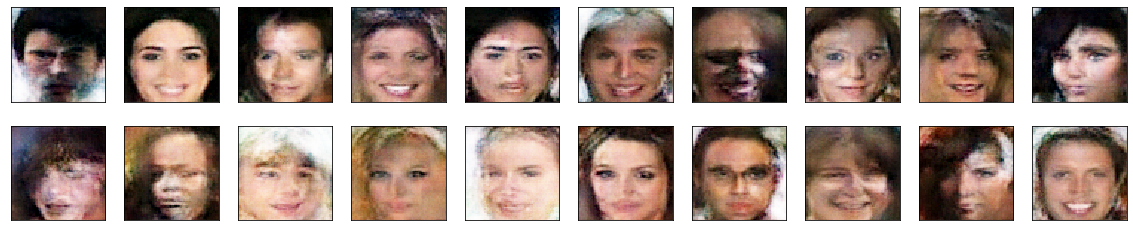

In [41]:
wgan_gp.train(3000, 
          generator, 
          dis_optimizer=Adam(lr=0.0002, beta_1=0.5),
          gen_optimizer=Adam(lr=0.0002, beta_1=0.5))

El resultado obtenido mejora a los anteriores. Son muestras de mayor calidad y con más diversidad. 